# IMDB 評論分類  
評論分成 positive 或是 negative 兩類，是一個二元分類問題。

In [1]:
import tensorflow as tf
from tensorflow import keras


In [2]:
imdb = keras.datasets.imdb

# 參數 num_words=10000 保留資料裡面出現最高頻率的 10000 個詞，低頻率出現的被移除
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

# show the first data
print(train_data[0])
print(len(train_data[0]))

Training entries: 25000, labels: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218


## 探勘數據  
從上述展示可以看到我們訓練集有 25000 筆資料，label 有 25000 種  
而第一筆電影評論長度為 218，且都被轉換成數字  
然而每則電影評論的長度不盡相同，如下：

In [4]:
print(len(max(train_data, key=len))) # 印出最長訓練評論的 size
print(len(max(test_data, key=len))) # 印出最長測試資料的 size
len(train_data[0]), len(train_data[1]), len(train_data[2])

2494
2315


(218, 189, 141)

而評論的標籤皆為 0 或是 1 的整數值，0 代表負面評論，1 代表正面評論  
如下我們展示前 20 筆標籤：

In [5]:
train_labels[0:20]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1])

## 準備數據  
這裡我們需要先將影評內容的 numpy array 轉換成 tensor，官方文件示範的方法為填充數據來讓每一則評論的長度相同，因為輸入到神經網路的 tensor 必須是相同的長度。這裡使用的方法為用 [pad sequences 函數](https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [6]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       padding='post',
                                                       maxlen=256)
# 經過處理後長度會相同
len(train_data[0]), len(train_data[1]), len(train_data[2])
                                            

(256, 256, 256)

In [7]:
print(train_data[0]) # 長度不夠的補 0 補到 256

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 建構模型  
須考慮你需要多少層的模型，模型每層裡面要有多少 hidden units

In [8]:
# 輸入的詞彙數量為 10000 種最高頻率出現的詞
vocab_size = 10000

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 16),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, None, 16)          160000    


 global_average_pooling1d (G  (None, 16)               0         


 lobalAveragePooling1D)                                          


 dense (Dense)               (None, 16)                272       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 160,289


Trainable params: 160,289


Non-trainable params: 0


_________________________________________________________________


2022-04-10 18:51:57.686412: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


## 創建驗證集  
先從訓練集分出一些資料來做驗證 validating  
測試集要拿來做測試，因為要拿模型沒看過的資料來做測試 testing



In [10]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 訓練模型


In [11]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=0
)

## 評估模型  
計算出損失值 loss，以及準確率 accuracy

In [12]:
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

782/782 - 0s - loss: 0.3336 - accuracy: 0.8722 - 426ms/epoch - 544us/step


[0.3336384892463684, 0.8722000122070312]


## 創建一個準確率和損失值隨時間變化的圖表  
`model.fit()` 有一個 `history` 的屬性

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

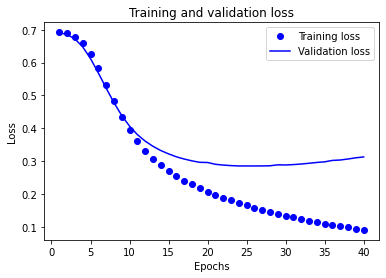

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "藍點"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“藍色實線”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

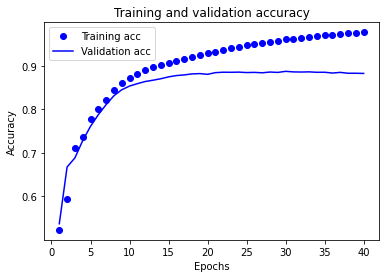

In [15]:
plt.clf()   # 清除數字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

從上述兩個圖看出大概在 epochs=15 的時候，即可訓練完成，再多可能會進入一個 over-fitting 的狀態。不過官方文件是說 epochs=20。

參考資料  
[官方文件](https://www.tensorflow.org/tutorials/keras/text_classification)